# PART 1. Data Pre-processing
## Step #0. Fire the system

In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,10)
plt.style.use('bmh')
import datetime as dt
from datetime import datetime
# from google.colab import drive 
# drive.mount('/content/drive')

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

## Step #1. Read data

In [2]:
# Importing Training Set
df = pd.read_csv('C:\\Users\\moham\\OneDrive - De Montfort University\\Final Project\\Master_Thesis\\Dataset\\QBDaily.csv', index_col=0, parse_dates=True)

array([<AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>,
       <AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>,
       <AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>,
       <AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>],
      dtype=object)

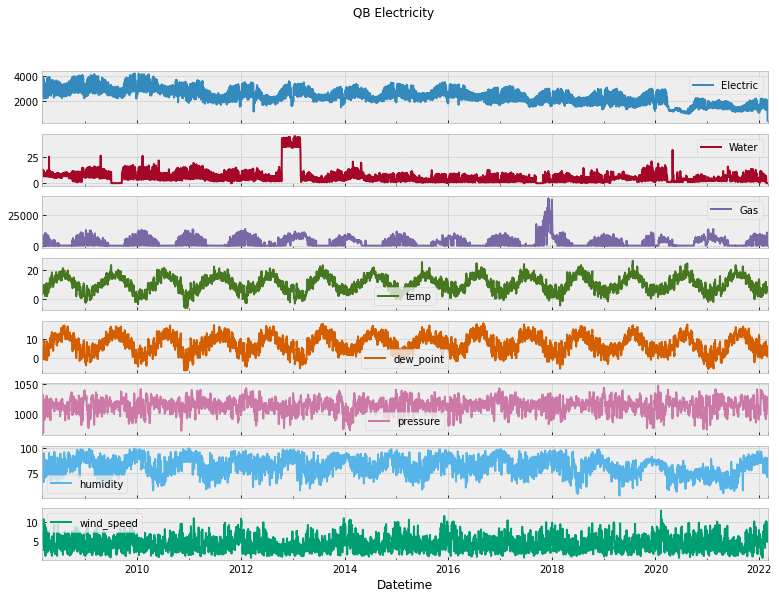

In [3]:
df.plot(subplots=True, figsize=(13,9), title='QB Electricity')

In [4]:
df = df.loc[:'2019-12-30']
data = df.reset_index()

dataset_train = data.copy()

dataset_train

,Datetime,Electric,Water,Gas,temp,dew_point,pressure,humidity,wind_speed
0,2008-03-03,2401.768,12.287,8989.587,4.422917,-0.175417,1010.041667,72.250000,5.371667
1,2008-03-04,3799.027,12.105,7309.673,3.310000,-0.861250,1026.375000,75.208333,5.100000
2,2008-03-05,3874.801,11.999,7250.323,4.049167,0.947083,1033.000000,80.291667,4.379167
3,2008-03-06,3799.476,11.937,4909.321,9.252500,5.157500,1021.916667,75.791667,5.761250
4,2008-03-07,3738.969,11.515,4905.515,7.638750,2.673333,1010.166667,71.750000,6.660833
...,...,...,...,...,...,...,...,...,...
4315,2019-12-26,1608.500,1.255,0.000,4.358333,2.606250,1016.291667,88.375000,4.367917
4316,2019-12-27,1562.000,1.584,0.000,5.761250,3.721667,1028.458333,86.708333,2.554583
4317,2019-12-28,1416.000,1.449,0.000,7.845000,5.699167,1034.708333,86.291667,4.385833
4318,2019-12-29,1232.999,1.469,0.000,6.718750,4.690417,1031.583333,86.875000,5.037917


In [5]:
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:9]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Datetime'])
# datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (4320, 9)
All timestamps == 4320
Featured selected: ['Electric', 'Water', 'Gas', 'temp', 'dew_point', 'pressure', 'humidity', 'wind_speed']


## Step #2. Data pre-processing
Removing all commas and convert data to matrix shape format.

In [6]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set[:1]

Shape of training set == (4320, 8).


array([[ 2.40176800e+03,  1.22870000e+01,  8.98958700e+03,
         4.42291667e+00, -1.75416667e-01,  1.01004167e+03,
         7.22500000e+01,  5.37166667e+00]])

In [7]:
# Feature Scaling
from sklearn.preprocessing import *

sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = MinMaxScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[0.40334369],
       [0.86616533],
       [0.89126436],
       ...,
       [0.07682243],
       [0.01620602],
       [0.0877532 ]])

In [8]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 860  # Number of days we want top predict into the future
n_past = 7     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (3454, 7, 7).
y_train shape == (3454, 1).


# PART 2. Create a model. Training
## Step #3. Building the LSTM based Neural Network

In [9]:
# Import Libraries and packages from Keras
from keras.models import *
from keras.layers import *

In [10]:
# # Initializing the Neural Network based on LSTM
# model = Sequential()

# # Adding 1st LSTM layer
# model.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# # Adding 2nd LSTM layer
# model.add(LSTM(units=128, activation='relu', return_sequences=True))

# # model.add(Dropout(0.2))

# model.add(LSTM(units=128, activation='relu', return_sequences=True))

# # model.add(Dropout(0.2))

# model.add(LSTM(units=128, activation='relu', return_sequences=True))

# # model.add(Dropout(0.2))

# model.add(LSTM(units=128, activation='relu', return_sequences=False))

# # Adding Dropout
# model.add(Dropout(0.2))

# # Output layer
# # model.add(Dense(units=64, activation='relu'))

# model.add(Dense(units=1))

# model = Sequential()
# model.add(LSTM(units=128, activation='relu', input_shape=(n_past, dataset_train.shape[1]-1), return_sequences=True))
# model.add(LSTM(units=128, activation='relu'))
# model.add(Dropout(rate=0.2))
# # model.add(Dense(units=8, activation='relu'))
# model.add(Dense(units=1))
# model.summary()

model = Sequential()
model.add(Bidirectional(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)))
model.add(Bidirectional(LSTM(units=128)))
model.add(Dropout(rate=0.2))
model.add(Dense(units=1))

# Compiling the Neural Network
model.compile(optimizer='adam', loss='mean_squared_error')

## Step #4. Start training

In [11]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=False, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1)

Epoch 1/100
84/87 [===========================>..] - ETA: 0s - loss: 0.0416
Epoch 1: val_loss improved from inf to 0.01884, saving model to weights.h5
87/87 [==============================] - 12s 30ms/step - loss: 0.0411 - val_loss: 0.0188 - lr: 0.0010
Epoch 2/100
86/87 [============================>.] - ETA: 0s - loss: 0.0272
Epoch 2: val_loss improved from 0.01884 to 0.01782, saving model to weights.h5
87/87 [==============================] - 1s 14ms/step - loss: 0.0272 - val_loss: 0.0178 - lr: 0.0010
Epoch 3/100
84/87 [===========================>..] - ETA: 0s - loss: 0.0266
Epoch 3: val_loss improved from 0.01782 to 0.01696, saving model to weights.h5
87/87 [==============================] - 1s 14ms/step - loss: 0.0266 - val_loss: 0.0170 - lr: 0.0010
Epoch 4/100
85/87 [============================>.] - ETA: 0s - loss: 0.0260
Epoch 4: val_loss improved from 0.01696 to 0.01633, saving model to weights.h5
87/87 [==============================] - 1s 15ms/step - loss: 0.0259 - val_loss:

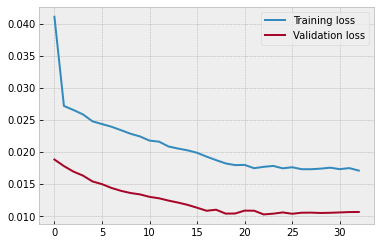

In [12]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

## PART 3. Make future predictions

In [13]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

## Step #5. Make predictions for future dates

In [14]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

predictions_train1 = model.predict(X_train)

## Step #6. Evaluate Metrics

In [15]:
from sklearn.metrics import *

print('RMSE: ', np.sqrt(mean_squared_error(y_train, predictions_train1)))
print('MSE: ', mean_squared_error(y_train, predictions_train1))
print('MAE: ', mean_absolute_error(y_train, predictions_train1))
print('R2: ', r2_score(y_train, predictions_train1)*100)

RMSE:  0.14171507483271822
MSE:  0.020083162434842924
MAE:  0.11424690057103701
R2:  22.787445410798433


In [16]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['value']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['value']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,value
2010-07-24,1805.444946
2010-07-25,1819.598145
2010-07-26,2308.055420


In [17]:
datelist_train = pd.to_datetime(datelist_train)

In [18]:
dataset_train = dataset_train.set_index(datelist_train)

In [19]:
dataset_train.head()

,Electric,Water,Gas,temp,dew_point,pressure,humidity,wind_speed
2008-03-03,2401.768,12.287,8989.587,4.422917,-0.175417,1010.041667,72.250000,5.371667
2008-03-04,3799.027,12.105,7309.673,3.310000,-0.861250,1026.375000,75.208333,5.100000
2008-03-05,3874.801,11.999,7250.323,4.049167,0.947083,1033.000000,80.291667,4.379167
2008-03-06,3799.476,11.937,4909.321,9.252500,5.157500,1021.916667,75.791667,5.761250
2008-03-07,3738.969,11.515,4905.515,7.638750,2.673333,1010.166667,71.750000,6.660833


## Step #6. Visualize the Predictions

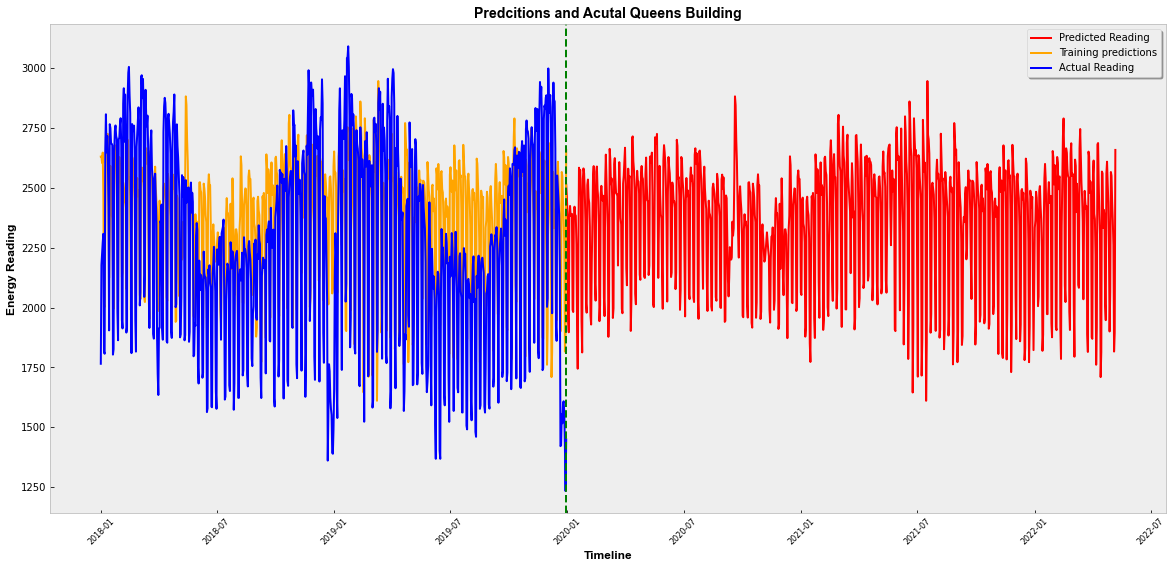

In [20]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 20, 9

# Plot parameters
START_DATE_FOR_PLOTTING = '2018-01-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['value'], color='r', label='Predicted Reading')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['value'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Electric'], color='b', label='Actual Reading')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Queens Building', family='Arial', fontsize=14, fontweight='bold')
plt.xlabel('Timeline', family='Arial', fontsize=12, fontweight='bold')
plt.ylabel('Energy Reading', family='Arial', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, fontsize=8)
plt.show()